In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import mlxtend



In [2]:
# load data
df2009_2010 = pd.read_csv("year2009-2010.csv", encoding="latin1")
df2010_2011 = pd.read_csv("year2010-2011.csv", encoding="latin1")

# rename invoice column
df2009_2010.rename(columns={df2009_2010.columns[0]: 'Invoice'}, inplace=True)
df2010_2011.rename(columns={df2010_2011.columns[0]: 'Invoice'}, inplace=True)

# remove non-customer transactions
df2010_2011 = df2010_2011.dropna(subset=['Customer ID'])
df2009_2010 = df2009_2010.dropna(subset=['Customer ID'])

#combine duplicate transactions
df2009_2010 = df2009_2010.groupby(['Invoice', 'StockCode', 'Customer ID'], as_index=False).agg({
    'Quantity': 'sum',
    'InvoiceDate': 'first',
    'Price': 'first',
    'Description': 'first',  
    'Country': 'first'       
})
df2010_2011 = df2010_2011.groupby(['Invoice', 'StockCode', 'Customer ID'], as_index=False).agg({
    'Quantity': 'sum',
    'InvoiceDate': 'first',
    'Price': 'first',
    'Description': 'first',  
    'Country': 'first'       
})

# add time features 
df2009_2010['InvoiceDate'] = pd.to_datetime(df2009_2010['InvoiceDate'])
df2009_2010['TimeOfDay'] = df2009_2010['InvoiceDate'].dt.hour
df2009_2010['DayOfWeek'] = df2009_2010['InvoiceDate'].dt.day_name()
df2010_2011['InvoiceDate'] = pd.to_datetime(df2010_2011['InvoiceDate'])
df2010_2011['TimeOfDay'] = df2010_2011['InvoiceDate'].dt.hour
df2010_2011['DayOfWeek'] = df2010_2011['InvoiceDate'].dt.day_name()

# calculate session duration
df2009_2010['SessionDuration'] = df2009_2010.groupby('Customer ID')['InvoiceDate'].diff().dt.total_seconds()
df2010_2011['SessionDuration'] = df2010_2011.groupby('Customer ID')['InvoiceDate'].diff().dt.total_seconds()

# calculate total sales amount
df2009_2010['TotalSalesAmount'] = df2009_2010['Quantity'] * df2009_2010['Price']
df2010_2011['TotalSalesAmount'] = df2010_2011['Quantity'] * df2010_2011['Price']

# revenue
df2009_2010['Revenue'] = df2009_2010['Quantity'] * df2009_2010['Price']
df2010_2011['Revenue'] = df2010_2011['Quantity'] * df2010_2011['Price']

# combine 2009-2010 and 2010-2011
df = pd.concat([df2009_2010, df2010_2011])

# split into purchases and returns
df_purchases = df[df['Quantity'] > 0]
df_returns = df[df['Quantity'] < 0]

                 Country
0              Australia
1                Austria
2                Bahrain
3                Belgium
4                 Brazil
5                 Canada
6        Channel Islands
7                 Cyprus
8         Czech Republic
9                Denmark
10                  EIRE
11    European Community
12               Finland
13                France
14               Germany
15                Greece
16               Iceland
17                Israel
18                 Italy
19                 Japan
20                 Korea
21               Lebanon
22             Lithuania
23                 Malta
24           Netherlands
25               Nigeria
26                Norway
27                Poland
28              Portugal
29                   RSA
30          Saudi Arabia
31             Singapore
32                 Spain
33                Sweden
34           Switzerland
35              Thailand
36                   USA
37  United Arab Emirates
38        United Kingdom


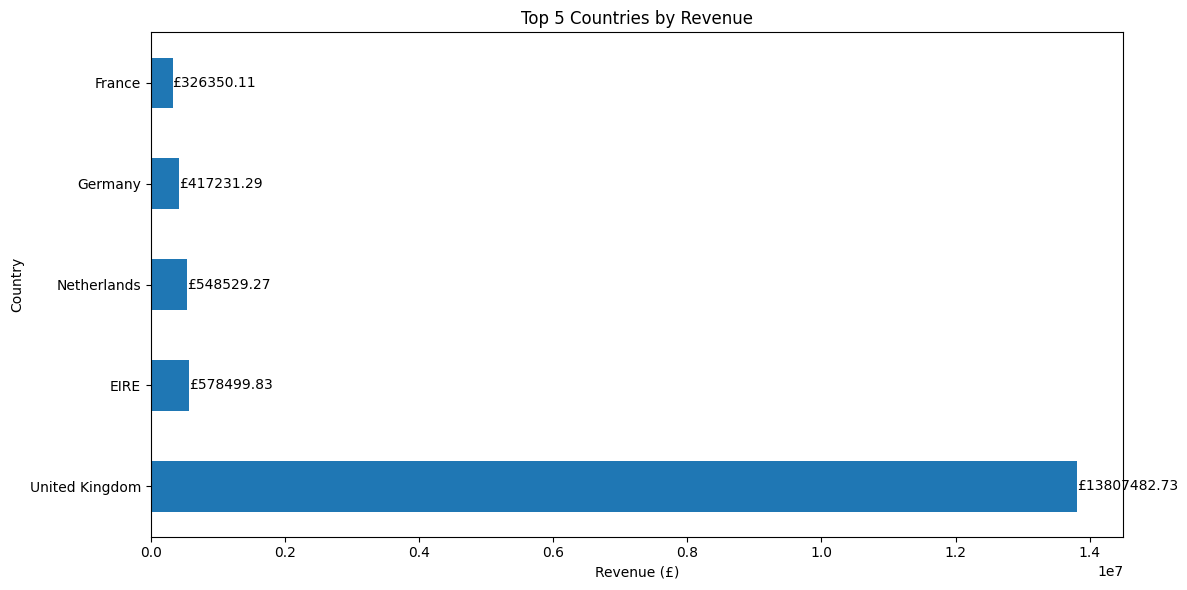

In [3]:
# list of countries in dataset
print(pd.DataFrame(sorted(df['Country'].unique()), columns=['Country']))
# countries by revenue
CountriesRevenue = df.groupby('Country')['Revenue'].sum().nlargest(5)
plt.figure(figsize=(12, 6))
CountriesRevenue.plot(kind='barh')
for index, value in enumerate(CountriesRevenue):
    plt.text(value, index, f'£{value:.2f}', va='center')
plt.title('Top 5 Countries by Revenue')
plt.xlabel('Revenue (£)')
plt.tight_layout()
plt.show()

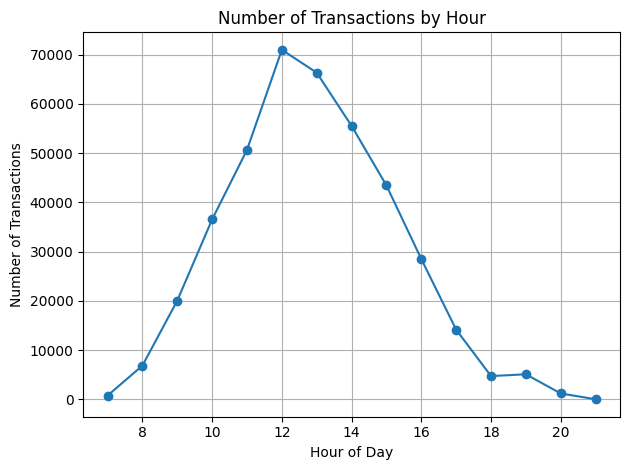

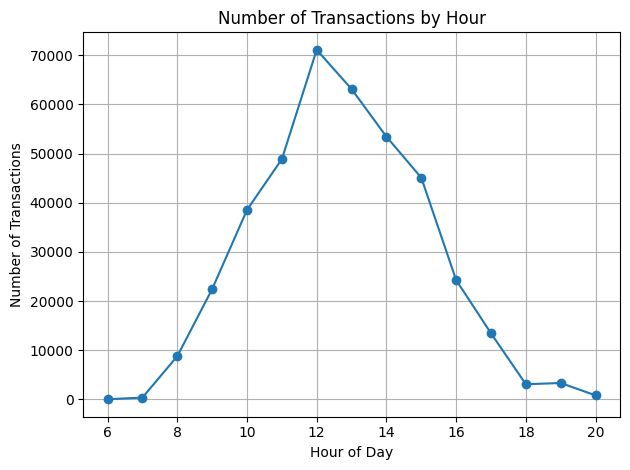

In [4]:
# visualize transactions by hour
HourlyTransactions = df2009_2010.groupby('TimeOfDay')['Invoice'].count()
HourlyTransactions.plot(kind='line', marker='o')
plt.title('Number of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

HourlyTransactions = df2010_2011.groupby('TimeOfDay')['Invoice'].count()
HourlyTransactions.plot(kind='line', marker='o')
plt.title('Number of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

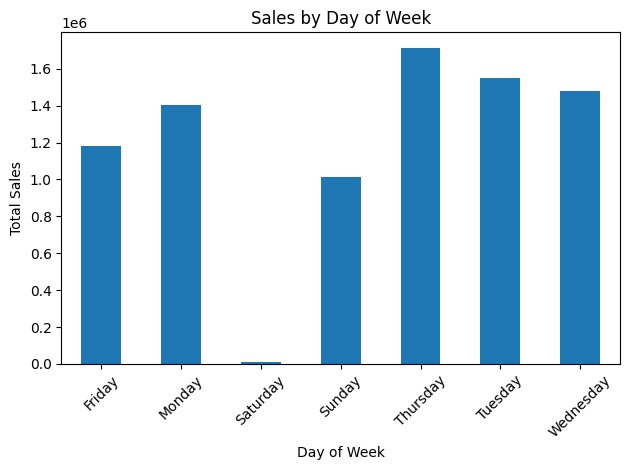

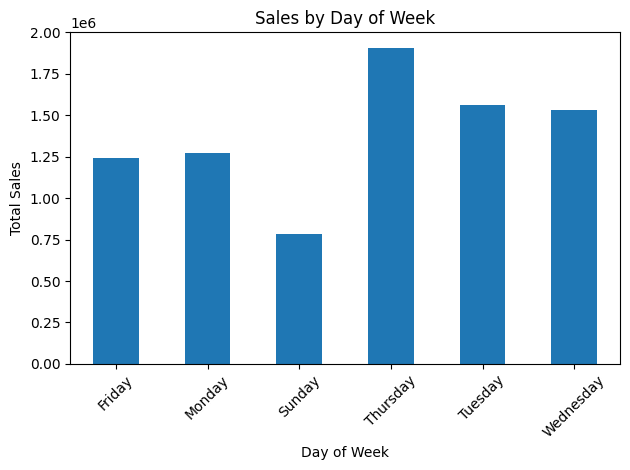

In [5]:
# visualize number of sales made according to day of week
DailySales = df2009_2010.groupby('DayOfWeek')['TotalSalesAmount'].sum()
DailySales.plot(kind='bar')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

DailySales = df2010_2011.groupby('DayOfWeek')['TotalSalesAmount'].sum()
DailySales.plot(kind='bar')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

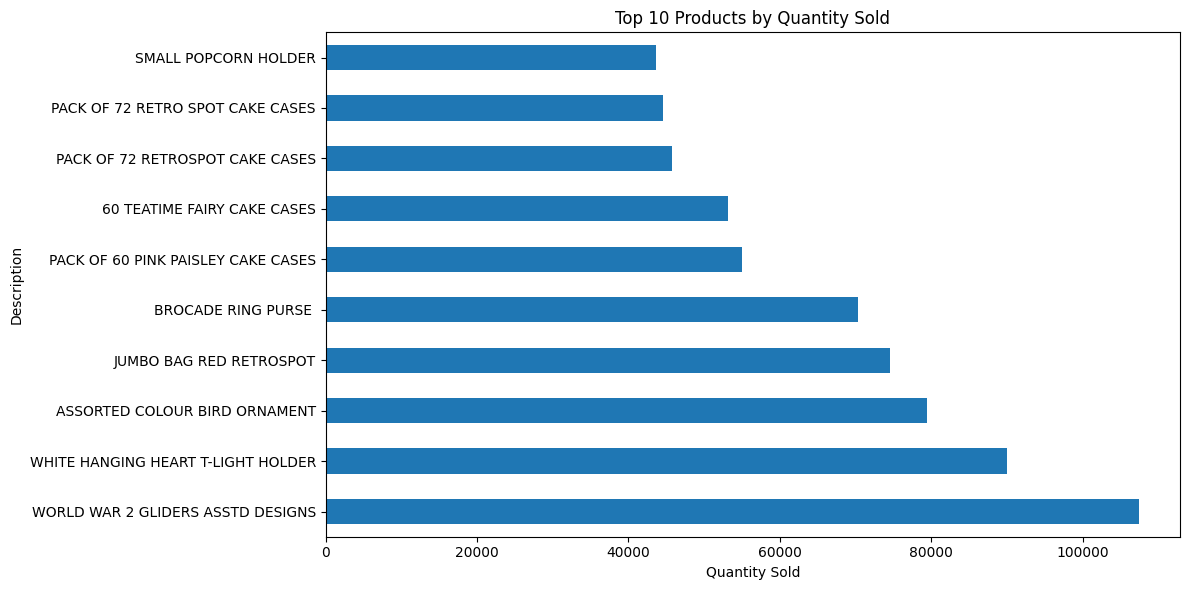

In [6]:
# determine top products sold
TopProducts = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
TopProducts.plot(kind='barh')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.tight_layout()
plt.show()

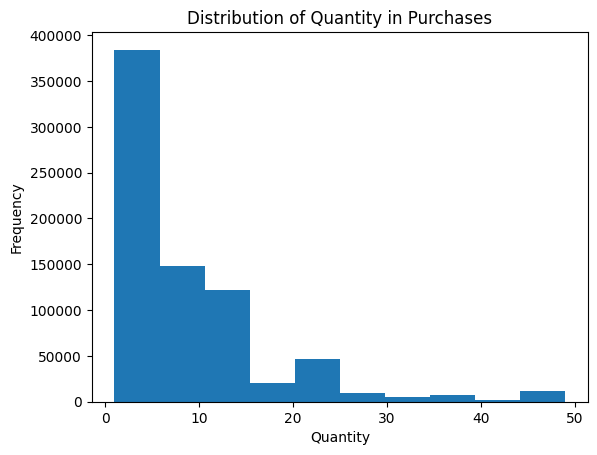

In [7]:
# distribution of quantity (purchases only, under 50)
plt.hist(df_purchases[df_purchases['Quantity'] < 50]['Quantity'])
plt.title('Distribution of Quantity in Purchases')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

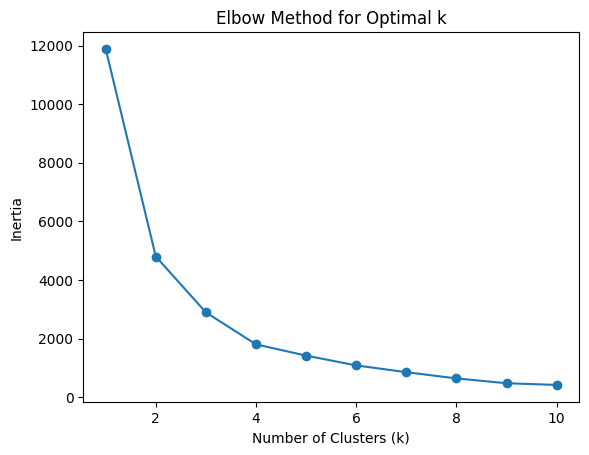

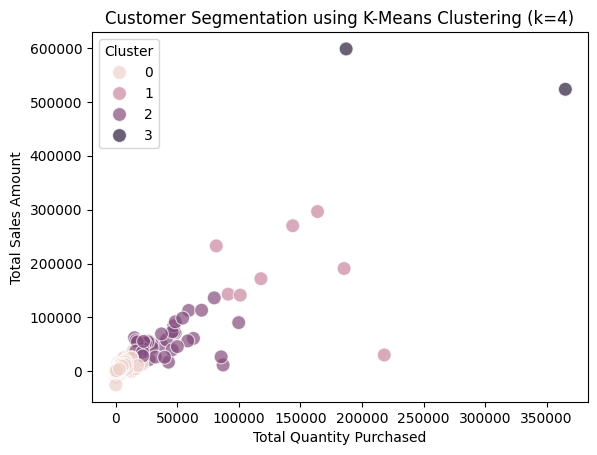

        Quantity  TotalSalesAmount
0    1171.448293       1985.037357
1  137893.750000     184688.346250
2   39069.511628      54878.308209
3  276165.000000     560780.805000


In [8]:
# clustering customers by sales/quantity purchased
customer_data = df.groupby('Customer ID').agg({
    'Quantity' : 'sum',
    'TotalSalesAmount': 'sum',
}).reset_index()

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['Quantity', 'TotalSalesAmount', ]])

# find best k with elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)
    
# show elbow plot
plt.plot(range(1, 11), inertia, marker = 'o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# elbow at k = 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# show clusters
sns.scatterplot(x='Quantity', y = 'TotalSalesAmount', hue = 'Cluster', data = customer_data, s = 100, alpha = 0.7)
plt.title(f'Customer Segmentation using K-Means Clustering (k={k})')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Total Sales Amount')
plt.legend(title='Cluster')
plt.show()
# average quantity and total sales by cluster
cluster_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Quantity', 'TotalSalesAmount'])
print(cluster_centroids)

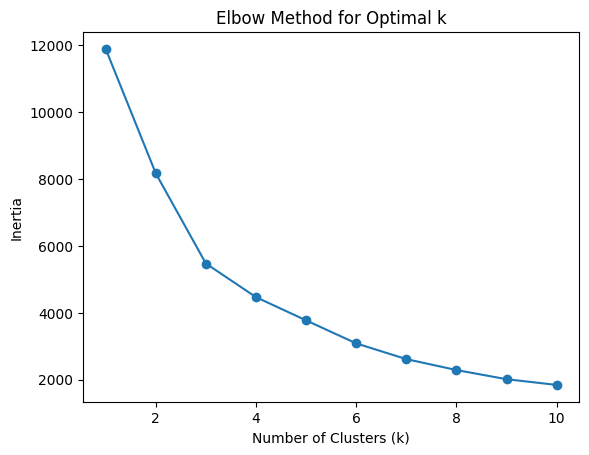

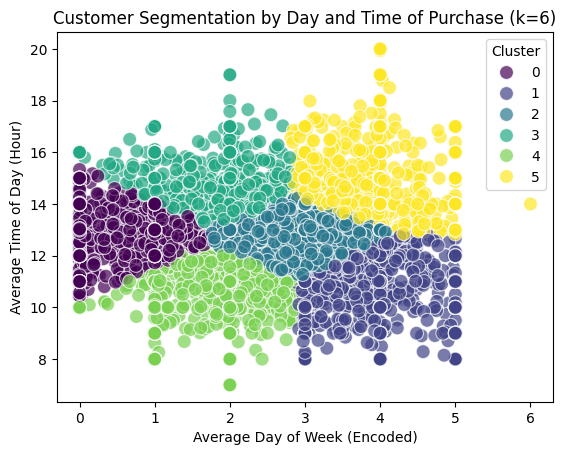

   DayOfWeek_Encoded  TimeOfDay DayOfWeek_Decoded
0           0.597604  12.870448            Monday
1           3.919853  10.730431          Thursday
2           2.825461  12.645565         Wednesday
3           1.808916  14.811358           Tuesday
4           1.826173  10.750618           Tuesday
5           3.890310  14.912293          Thursday


In [9]:
# cluster customers by day of week and time of purchases

# map DayOfWeek to numerical values
day_mapping = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
df['DayOfWeek_Encoded'] = df['DayOfWeek'].map(day_mapping)

customer_data = df.groupby('Customer ID').agg({
    'DayOfWeek_Encoded': 'mean',  # Use the mean of the encoded day for each customer
    'TimeOfDay': 'mean'           # Average purchase time of day
}).reset_index()

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['DayOfWeek_Encoded', 'TimeOfDay']])

# find best k with elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

# show elbow plot
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# elbow at k = 6
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# show clusters
sns.scatterplot(
    x='DayOfWeek_Encoded', 
    y='TimeOfDay', 
    hue='Cluster', 
    data=customer_data, 
    palette='viridis', 
    s=100, alpha=0.7
)
plt.title(f'Customer Segmentation by Day and Time of Purchase (k={k})')
plt.xlabel('Average Day of Week (Encoded)')
plt.ylabel('Average Time of Day (Hour)')
plt.legend(title='Cluster')
plt.show()

# Decode cluster centers to original scale
cluster_centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    columns=['DayOfWeek_Encoded', 'TimeOfDay']
)
cluster_centroids['DayOfWeek_Decoded'] = cluster_centroids['DayOfWeek_Encoded'].round().map({v: k for k, v in day_mapping.items()})
print(cluster_centroids)


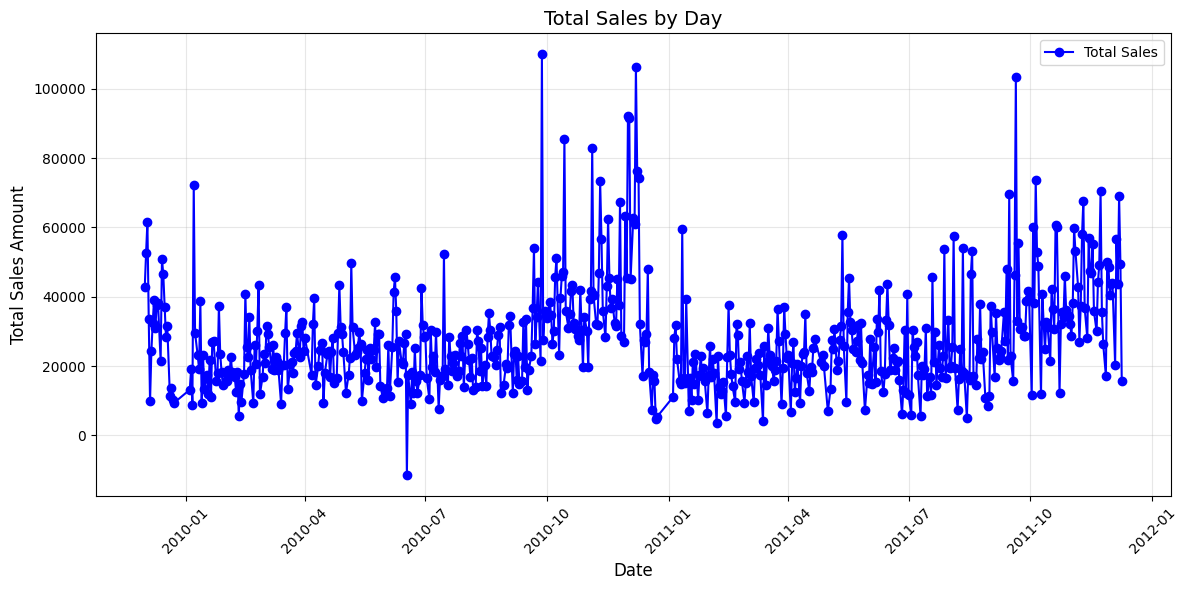

In [10]:
# total sales by day
df['Date'] = df['InvoiceDate'].dt.date
sales_by_day = df.groupby('Date')['TotalSalesAmount'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_day['Date'], sales_by_day['TotalSalesAmount'], marker='o', color='blue', label='Total Sales')
plt.title('Total Sales by Day', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
plt.xticks(rotation=45)  
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# association rule mining for items purchased together

transactions = df.groupby('Invoice')['StockCode'].apply(list).reset_index()
te = TransactionEncoder()
te_data = te.fit(transactions['StockCode']).transform(transactions['StockCode'])
df_trans = pd.DataFrame(te_data, columns=te.columns_)


frequent_itemsets = apriori(df_trans, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=len(frequent_itemsets))
strong_rules = rules[rules['lift'] > 1]


Frequent Itemsets:
      support                 itemsets
0    0.014418                  (15036)
1    0.017827                (15056BL)
2    0.019676                 (15056N)
3    0.012078                  (20675)
4    0.016334                  (20676)
..        ...                      ...
634  0.010250    (22383, 22382, 20728)
635  0.010228    (84991, 21977, 21212)
636  0.010785  (85099B, 22386, 85099F)
637  0.010005    (22423, 22699, 22697)
638  0.012301    (22699, 22698, 22697)

[639 rows x 2 columns]
Strong Rules:
        antecedents     consequents   support  confidence       lift
0           (22356)         (20724)  0.015821    0.625551  18.335866
1           (21094)         (21080)  0.010674    0.687231  18.335421
2           (21086)         (21094)  0.010964    0.787200  50.683482
3           (21094)         (21086)  0.010964    0.705882  50.683482
4           (21122)         (21124)  0.010763    0.650067  48.459169
5           (21124)         (21122)  0.010763    0.802326  48

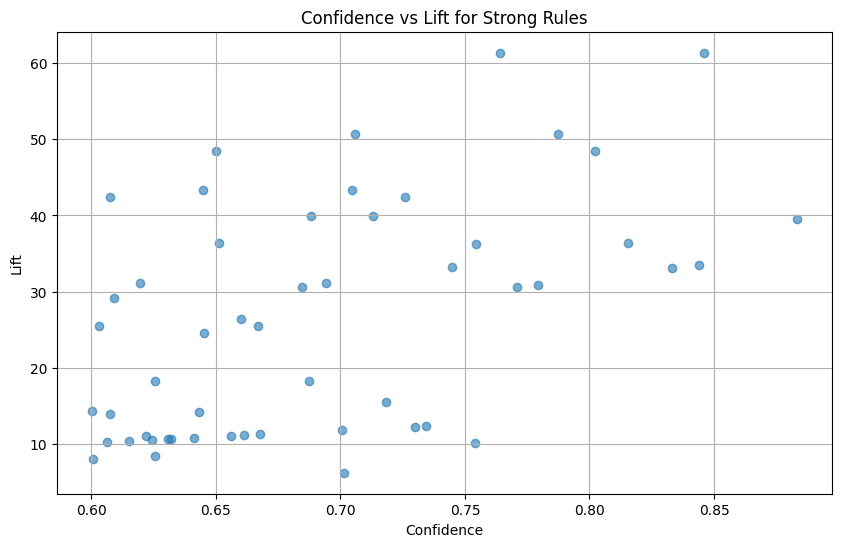

In [ ]:
# Plot Confidence vs Lift
plt.figure(figsize=(10, 6))
plt.scatter(strong_rules['confidence'], strong_rules['lift'], alpha=0.6)
plt.title('Confidence vs Lift for Strong Rules')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.grid(True)
plt.show()


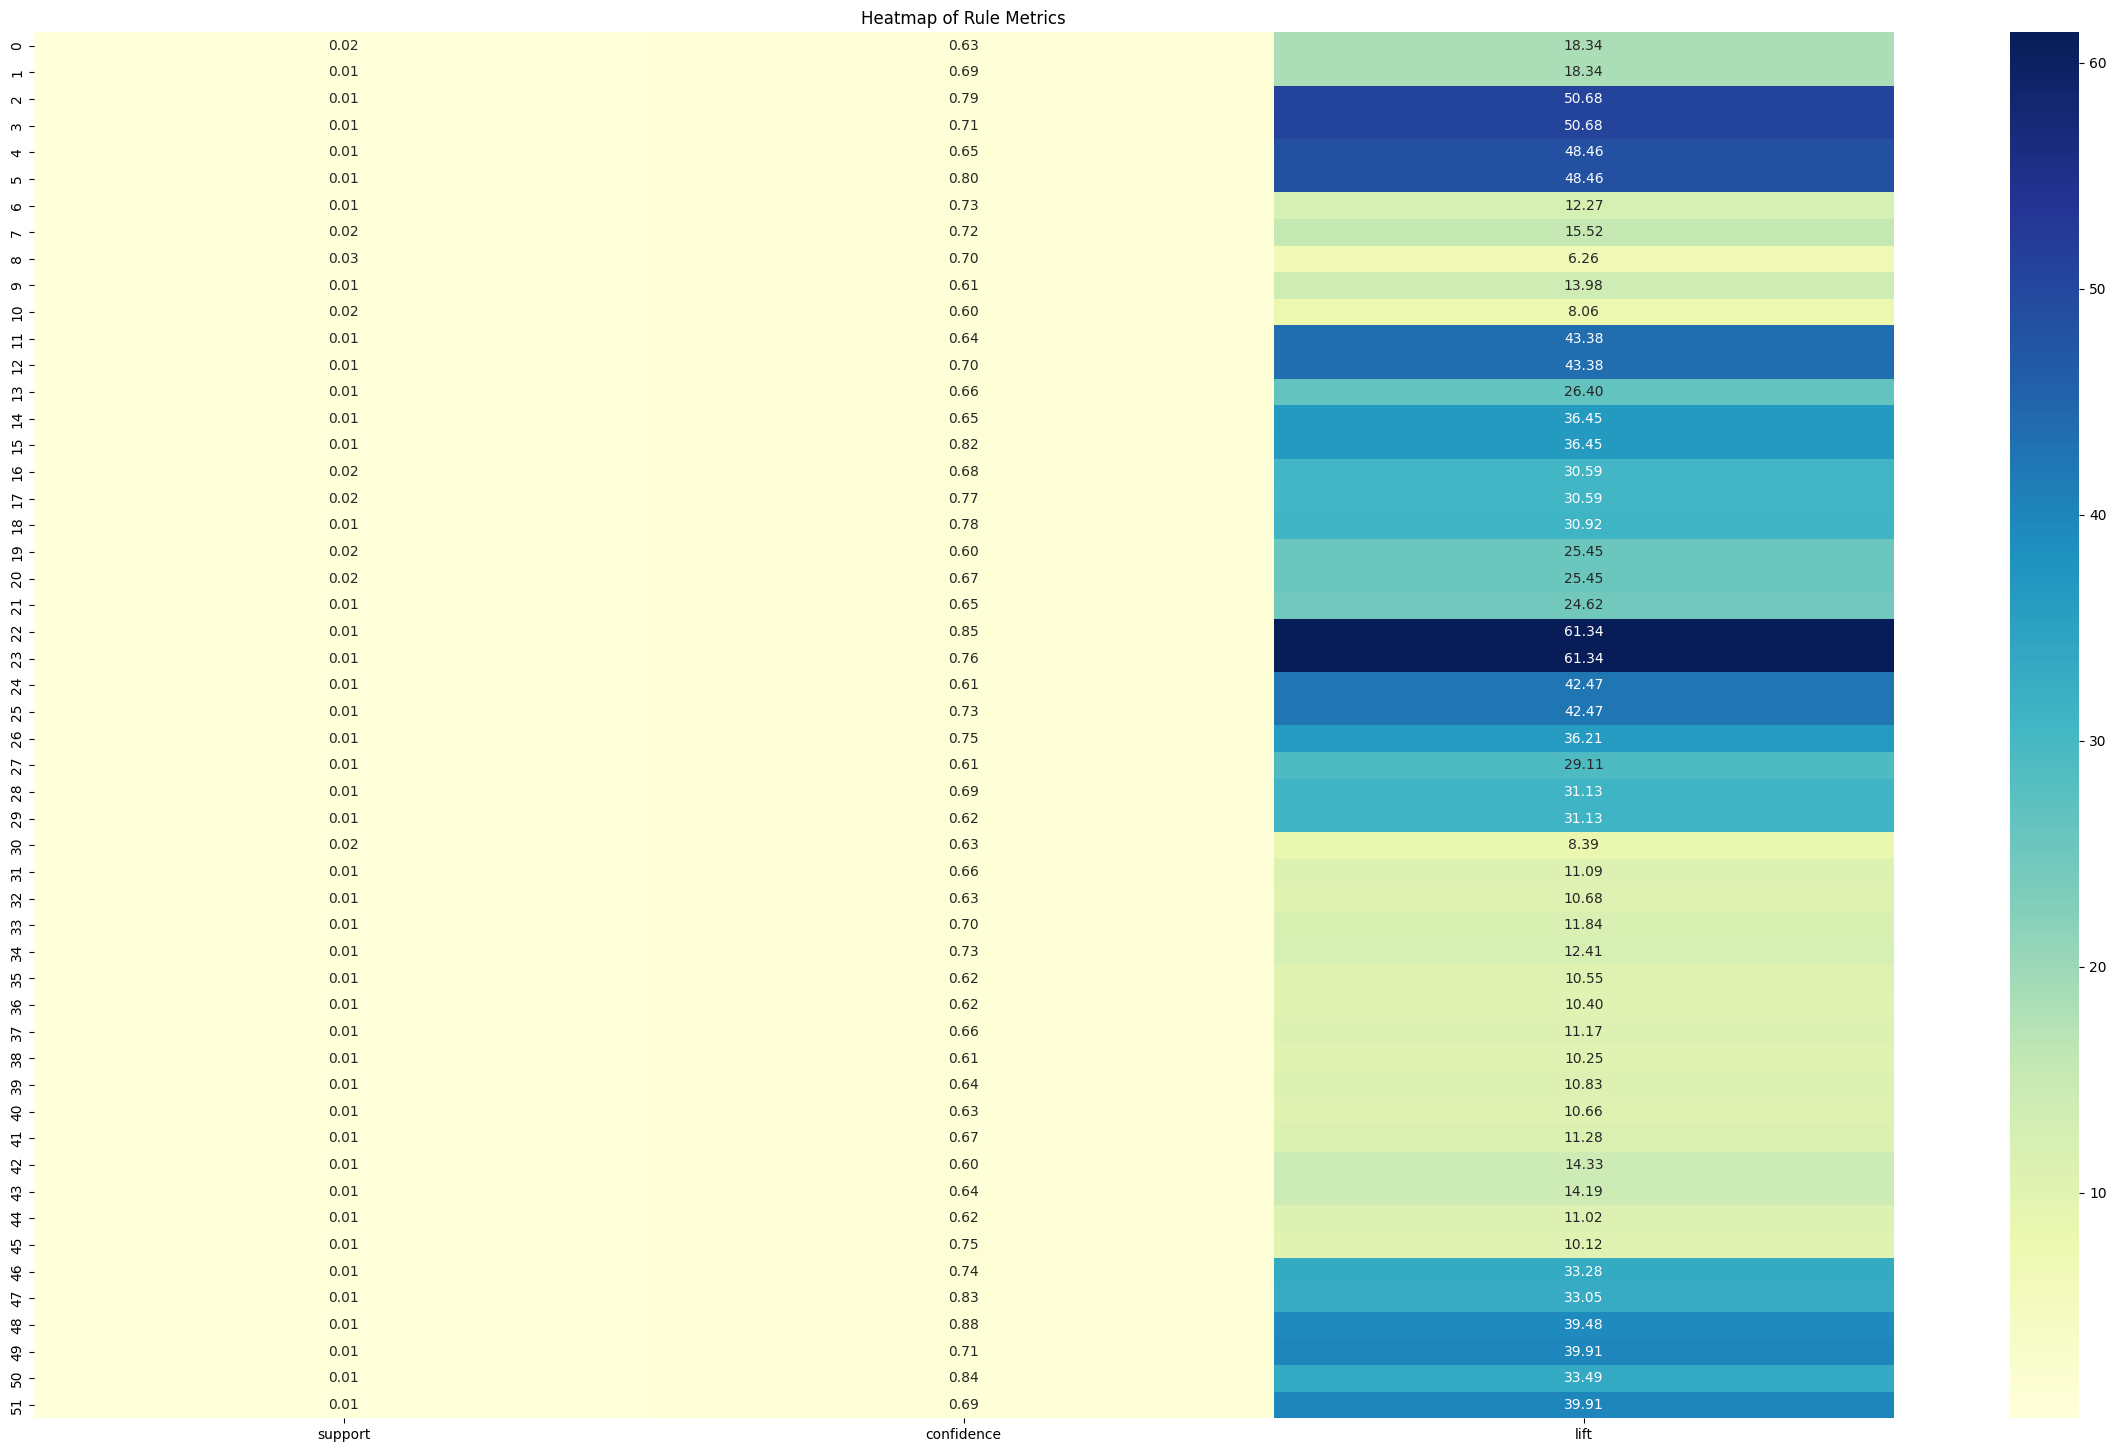

In [ ]:
# heatmap of rule metrics
rule_metrics = strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
plt.figure(figsize=(30, 18))
sns.heatmap(rule_metrics[['support', 'confidence', 'lift']], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Rule Metrics')
plt.show()


In [ ]:
# sort rules by lift and show top 10
top_rules = strong_rules.sort_values(by='lift', ascending=False).head(10)
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


   antecedents consequents   support  confidence       lift
22     (22745)     (22748)  0.010540    0.846154  61.344103
23     (22748)     (22745)  0.010540    0.764136  61.344103
3      (21094)     (21086)  0.010964    0.705882  50.683482
2      (21086)     (21094)  0.010964    0.787200  50.683482
5      (21124)     (21122)  0.010763    0.802326  48.459169
4      (21122)     (21124)  0.010763    0.650067  48.459169
11     (22577)     (22578)  0.010473    0.644719  43.376912
12     (22578)     (22577)  0.010473    0.704648  43.376912
24     (23301)     (23300)  0.010384    0.607562  42.468768
25     (23300)     (23301)  0.010384    0.725857  42.468768


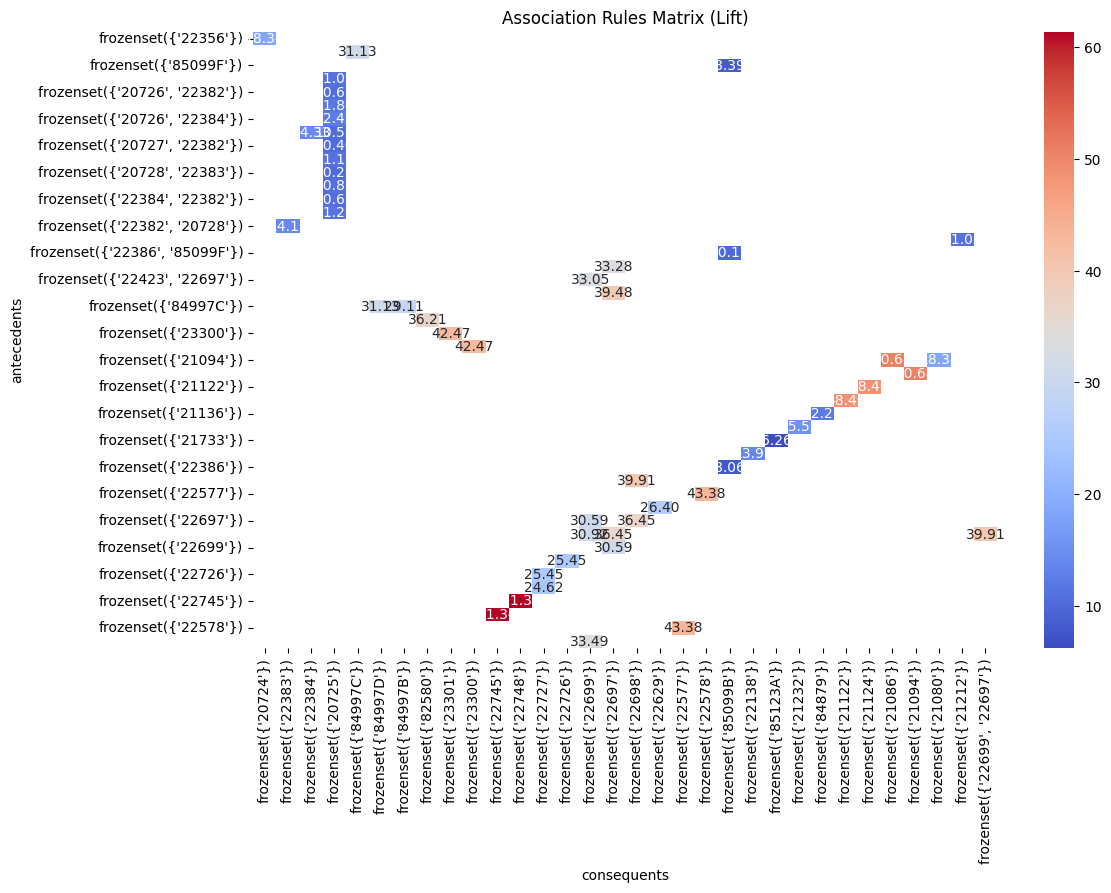

In [ ]:
# plotting association rules as matrix plot
rules_matrix = strong_rules.pivot_table(index='antecedents', columns='consequents', values='lift', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(rules_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Association Rules Matrix (Lift)')
plt.show()


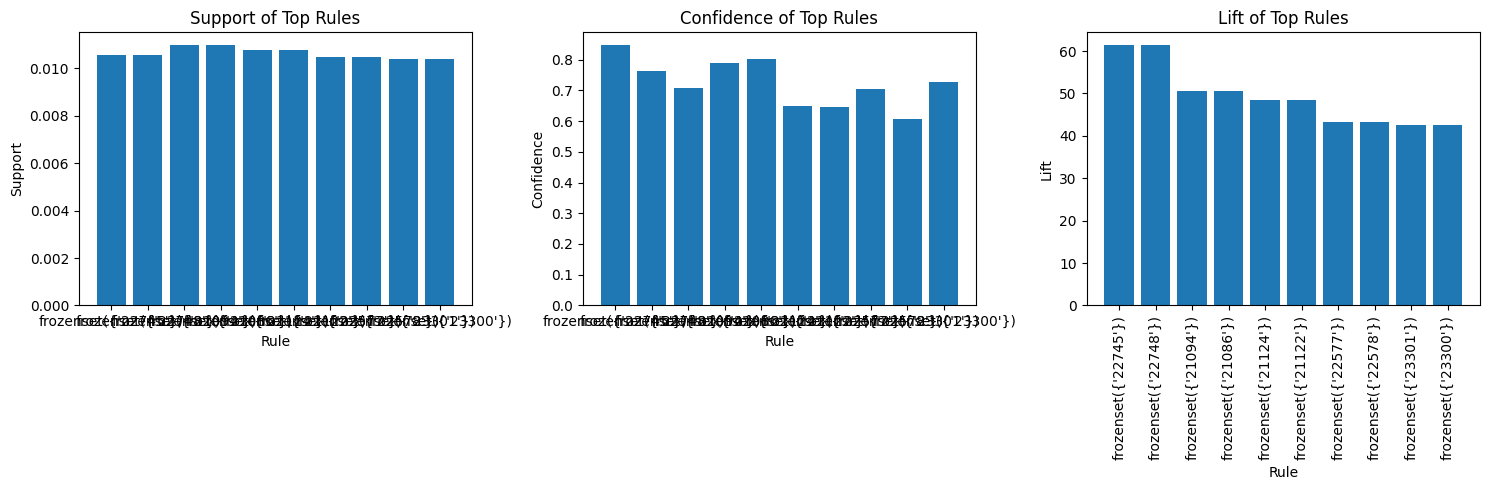

In [ ]:
# bar plots for support, confidence, and lift of top rules
top_rules = strong_rules.sort_values(by='lift', ascending=False).head(10)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(top_rules['antecedents'].astype(str), top_rules['support'])
axes[0].set_title('Support of Top Rules')
axes[0].set_xlabel('Rule')
axes[0].set_ylabel('Support')

axes[1].bar(top_rules['antecedents'].astype(str), top_rules['confidence'])
axes[1].set_title('Confidence of Top Rules')
axes[1].set_xlabel('Rule')
axes[1].set_ylabel('Confidence')

axes[2].bar(top_rules['antecedents'].astype(str), top_rules['lift'])
axes[2].set_title('Lift of Top Rules')
axes[2].set_xlabel('Rule')
axes[2].set_ylabel('Lift')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
